In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
import glob
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
from nibabel.viewers import OrthoSlicer3D
from nibabel import nifti1
import nibabel as nib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
example_filename1='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/preprocessed/training01_01_flair_pp.nii'
example_filename2='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/preprocessed/training01_01_pd_pp.nii'
example_filename3='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/preprocessed/training01_01_t2_pp.nii'
example_filename1_mask='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/masks/training01_01_mask1.nii'

img1 = nib.load(example_filename1)
img2=nib.load(example_filename2)
img3=nib.load(example_filename3)
img1_mask=nib.load(example_filename1_mask)
img1=img1.get_fdata()
img2=img2.get_fdata()
img3=img3.get_fdata()
img1_mask=img1_mask.get_fdata()


In [4]:
img1.shape

(181, 217, 181)

In [5]:
img1=img1.astype('float32')/255.0
img2=img2.astype('float32')/255.0
img3=img3.astype('float32')/255.0
img1_mask=img1_mask.astype('uint8')


In [6]:
from random import choice
new_h, new_w = 100, 400
train_img_masks=[]
train_img_masks1=[]
for i in tqdm(range(img1.shape[2])):
    img_resize1 = img1[:,:,i]
    mask_resize1 = np.uint8(img1_mask[:,:,i])
    train_img_masks1.append((img_resize1, mask_resize1))
    
train_img_masks2=[]
for i in tqdm(range(img2.shape[2])):
    img_resize2 = img2[:,:,i]
    mask_resize2 = np.uint8(img1_mask[:,:,i])
    train_img_masks2.append((img_resize2, mask_resize2))
train_img_masks3=[]
for i in tqdm(range(img3.shape[2])):
    img_resize3 = img3[:,:,i]
    mask_resize3 = np.uint8(img1_mask[:,:,i])
    train_img_masks3.append((img_resize3, mask_resize3))

val_img_masks=random.sample(train_img_masks1, 150)



100%|██████████| 181/181 [00:00<00:00, 66250.90it/s]


In [7]:
len(train_img_masks2)

181

In [8]:
train_img_masks=[]
for i in range(len(train_img_masks3)):
    
    q1=np.zeros([train_img_masks3[0][0].shape[0],train_img_masks3[0][0].shape[1],3])
    q1[:,:,0]=train_img_masks1[i][0]
    q1[:,:,1]=train_img_masks2[i][0]
    q1[:,:,2]=train_img_masks3[i][0]
    
    
    t=(q1,train_img_masks1[i][1])
    train_img_masks.append(t)


In [9]:
len(train_img_masks3)

181

Text(0.5,1,'flair sample image')

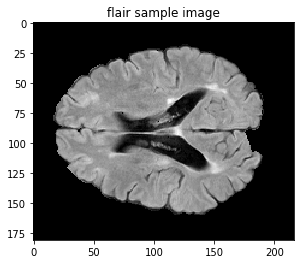

In [10]:
plt.imshow(train_img_masks1[181//2][0], cmap = 'gray')
plt.title("flair sample image")

Text(0.5,1,'pd sample image')

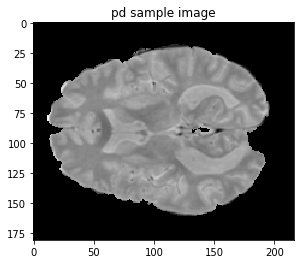

In [11]:
plt.imshow(train_img_masks2[80][0], cmap = 'gray')
plt.title("pd sample image")

Text(0.5,1,'t2 sample image')

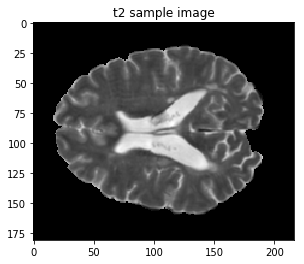

In [12]:
plt.imshow(train_img_masks3[181//2][0], cmap = 'gray')
plt.title("t2 sample image")

Text(0.5,1,'mask image')

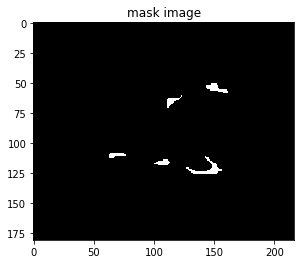

In [13]:
plt.imshow(train_img_masks[181//2][1], cmap = 'gray')
plt.title("mask image")

In [14]:

# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Conv2d(in_ch,out_ch,3,padding=(1,1))
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d((2,2))
    def forward(self, x):
        x = self.down(x)
        return x


class up_layer(nn.Module):
    def __init__(self):
        super(up_layer, self).__init__()       
        self.up = nn.Upsample(scale_factor = 2, mode='bilinear')
        # Note: after up, we also concatenate with previously saved feature x2

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # upsample x1 to be same size as x2
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        

        x = torch.cat([x2, x1], dim=1)
        
        return x



class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch,out_ch,3,padding=(1,1))

    def forward(self, x):
        x = self.conv(x)
        x = torch.sigmoid(x)
        return x
    

In [15]:

import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels_in, 16) 
        self.down1 = down_layer()
        self.conv1 = single_conv(16,32)
        self.down2 = down_layer()
        self.conv2 = single_conv(32,32)
        self.up1 = up_layer()
        self.conv3 = single_conv(64,16)  
        self.up2 = up_layer()
        self.conv4 = single_conv(32,16)                  

        self.outc = outconv(16,n_channels_out)                 

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.down2(x2)
        x3 = self.conv2(x3)
        

        x = self.up1(x3, x2)
        x = self.conv3(x)
        x = self.up2(x,x1)
        x = self.conv4(x)
        x = self.outc(x)
        return x
    

In [16]:

# define dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0

        A = prediction.view(-1)
        B = target.view(-1)
        
        inter = torch.dot(A.float(),B.float())
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
        # Calculate DICE 
        d = inter / union
        return d



# Calculate dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s


In [17]:

class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=1.0):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
           
            img_flip = img[:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 
        
        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = self.image_masks[index][0]
        mask = self.image_masks[index][1]
        
        image = np.transpose(image, axes=[2, 0, 1]) 
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_img=[]
val_img=[]

for i in range(len(train_img_masks)):
    train_img.append((train_img_masks[i][0][:, : ,:],train_img_masks[i][1][:, : ]))
for i in range(len(val_img_masks)):
    val_img.append((val_img_masks[i][0][:, : ,np.newaxis],val_img_masks[i][1][:, :]))

train_dataset = CustomDataset(train_img, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img, transforms=transforms.Compose([Flip(),ToTensor()]))

In [18]:
train_img_masks[0][0].shape

(181, 217, 3)

In [19]:

def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)
        mask_pred = net(img.float())
        
        mask_pred = mask_pred > 0.5
        
        
        #zero = torch.zeros_like(mask_pred)
        #one = torch.ones_like(mask_pred)
        
        #mask_pred = torch.where(mask_pred > 0.5, one, mask_pred)
        #mask_pred = torch.where(mask_pred <= 0.5, zero, mask_pred)
        
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together 
        tot += dice_coeff(true_mask,mask_pred)
        # Return average dice_coeff()
    return tot / (i + 1)

In [20]:

net = UNet(3,1)
net.to(device)
print(net)

# If continuing from previously saved model, run
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))


n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (inc): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up1): up_layer(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv3): single_conv(
    (

In [40]:

epochs =10 # e.g. 10, or more until dice converge
batch_size = 1 # e.g. 16
lr = 0.05        # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = './model/'  # directory to same the model after each epoch. 
aa=[]
bb=[]
cc=[]

optimizer = optim.SGD(net.parameters(),lr = lr,momentum=0.9, weight_decay=0.0005)

# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.BCELoss()

# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    for i, b in enumerate(train_loader):
      
        imgs = b['img'].to(device)
        #print(imgs.shape)
        true_masks = b['label'].to(device)

     
        masks_pred = net.forward(imgs.float())
#         masks_pred = nn.functional.interpolate(masks_pred, size=(80,100), mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        
        aa.append(masks_pred.detach().numpy())
        bb.append(imgs[0,:,:,:].float().numpy())
        
        
        masks_probs_flat = masks_pred.view(-1)
        true_masks_flat = true_masks.view(-1)
        #print(true_masks.shape)
       
        loss = criterion(masks_probs_flat,true_masks_flat.float())
        
        cc.append(true_masks[0,:,:].numpy())
        epoch_loss += loss.item()
        #print(N_train)
        if count % 50 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

    val_dice = eval_net(net,train_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

Starting epoch 1/10.
0.0000 --- loss: 0.000374


/Users/lixiang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.2762 --- loss: 0.000309
0.5525 --- loss: 0.000171
0.8287 --- loss: 0.000306
Epoch finished ! Loss: 0.004377106402292459
Validation Dice Coeff: tensor([0.])
Checkpoint 1 saved !
Starting epoch 2/10.
0.0000 --- loss: 0.006513
0.2762 --- loss: 0.002204
0.5525 --- loss: 0.012216
0.8287 --- loss: 0.015633
Epoch finished ! Loss: 0.0053528226938700145
Validation Dice Coeff: tensor([0.])
Checkpoint 2 saved !
Starting epoch 3/10.
0.0000 --- loss: 0.000204
0.2762 --- loss: 0.000159
0.5525 --- loss: 0.000239
0.8287 --- loss: 0.000282
Epoch finished ! Loss: 0.004300113434712532
Validation Dice Coeff: tensor([0.])
Checkpoint 3 saved !
Starting epoch 4/10.
0.0000 --- loss: 0.000363
0.2762 --- loss: 0.000789
0.5525 --- loss: 0.017383
0.8287 --- loss: 0.000380
Epoch finished ! Loss: 0.004251364556775015
Validation Dice Coeff: tensor([0.0008])
Checkpoint 4 saved !
Starting epoch 5/10.
0.0000 --- loss: 0.003512
0.2762 --- loss: 0.000249
0.5525 --- loss: 0.018824
0.8287 --- loss: 0.000224
Epoch finishe

In [41]:

def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    #net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    full_img = np.transpose(full_img,[2,0,1])
    
    # convert numpy array to torch tensor, normalize to range (0,1)
    X_img = torch.from_numpy(full_img).unsqueeze(0).to(device)
    #plt.imshow(X_img[0][0],cmap='gray')
    #print(X_img[0,0,80,80])
    with torch.no_grad():
        
        output_img = net.forward(X_img.float())
        
        out_probs = output_img.squeeze(0).squeeze(0)
        #print(out_probs.numpy()[:,40])
        #plt.imshow(out_probs.numpy(),cmap='gray')
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8 
        out_mask_np = (out_probs>out_threshold).cpu().numpy().astype('uint8')
        

    # For all pixels in predicted mask, set them to 1 if larger than out_threshold. Otherwise set them to 0
#     return out_mask_np
    return out_mask_np


In [48]:
test_img = train_img_masks[70][0]
test_img_mask_ori=train_img_masks[70][1]



#img_resize = cv2.resize(test_img,(100,80))
#img_resize = test_img[:, : ,np.newaxis]

#plt.imshow(img_resize[:,:,0],cmap='gray')
mask = predict_img(net=net,
                    full_img=test_img,
                    out_threshold=0.01)
#print(sum(mask==0))
# Rescale the mask back to original image size

#mask =  cv2.resize(mask,(orig_shape[1],orig_shape[0]))

/Users/lixiang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Predict_Mask')

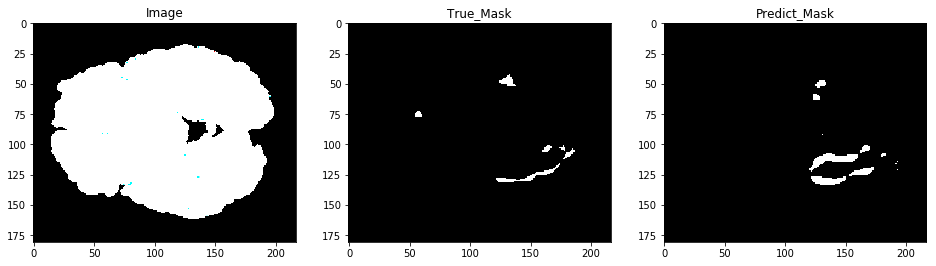

In [49]:
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(test_img,cmap='gray')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(test_img_mask_ori,cmap='gray')
plt.title('True_Mask')
plt.subplot(1,3,3)
plt.imshow(mask,cmap='gray')
plt.title('Predict_Mask')

In [25]:
dice_coeff(torch.from_numpy(test_img_mask_ori).contiguous(),torch.from_numpy(mask))

tensor([0.0599])

In [26]:
torch.from_numpy(mask).view(-1)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [27]:
target=prediction=torch.from_numpy(mask)
A = prediction.view(-1)
B = target.view(-1)
        
inter = torch.dot(A.float(),B.float())
union = torch.sum(A.float()) + torch.sum(B.float()) - inter + 0.001

In [28]:
torch.from_numpy(test_img_mask_ori).contiguous().view(-1)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [29]:
torch.from_numpy(mask).view(-1)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [30]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [31]:
test_img_mask_ori

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)